### transfer learning from `FaceForensics++`

In [1]:
from fastai.vision import *
from tqdm import tqdm

In [9]:
data_path = Path("/home/ubuntu/data/dfdc")

In [10]:
video_path = data_path/"dfdc_train/dfdc_train_part_49"

In [11]:
metadata = get_files(video_path, extensions=['.json'])

In [12]:
video_files = get_files(video_path, extensions=['.mp4'])

In [13]:
def read_metadata(fn):
    metadf = pd.read_json(fn).T.reset_index()
    metadf.columns = ['fname','label','split','original']
    return metadf 

In [14]:
metadf = read_metadata(metadata[0])

In [15]:
metadf.head()

,fname,label,split,original
0,dwwytkheyx.mp4,FAKE,train,nlcqykqsdp.mp4
1,bdsxxaamze.mp4,FAKE,train,xzmplldajk.mp4
2,tfceaqvefa.mp4,FAKE,train,zkksmnscsf.mp4
3,lurozpmsqd.mp4,FAKE,train,urbulrzowx.mp4
4,jvlvkijuwa.mp4,FAKE,train,wvnjcwevzo.mp4


In [16]:
metadf.groupby("label")[["fname",'original']].count()

,fname,original
label,,
FAKE,2619,2619
REAL,515,0


In [17]:
torch.ones(2, requires_grad=True)+1

tensor([2., 2.], grad_fn=<AddBackward0>)

### load xception

In [24]:
sys.path.insert(0,'/home/ubuntu/git/dfdc/local_misc/faceforensics-pretrained/FaceForensics/classification/')

In [25]:
xception_model_path = "/home/ubuntu/git/dfdc/local_misc/faceforensics-pretrained/faceforensics_models_subset/xception/full_raw.p"

In [27]:
xception_model = torch.load(xception_model_path);
requires_grad(xception_model, True)
model = xception_model.model

/home/ubuntu/anaconda3/envs/deepfake/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'network.models.TransferModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ubuntu/anaconda3/envs/deepfake/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'pretrainedmodels.models.xception.Xception' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/ubuntu/anaconda3/envs/deepfake/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrie

In [28]:
xb = torch.randn((1,3,299,299)).cuda()

In [29]:
model(xb).softmax(1)

tensor([[0.5960, 0.4040]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### naive validation 

In [15]:
# create validation sample
sample_ratio = 0.05

In [16]:
# original videos that are in training videos
train_video_fnames = list(map(lambda o: o.name, video_files))
original_video_fnames = [o for o in metadf.original.values if o in train_video_fnames]
# sample from original videos
valid_original_videos = np.random.choice(original_video_fnames, int(len(original_video_fnames)*sample_ratio))

In [17]:
len(valid_original_videos)

130

In [18]:
# get all corresponding fakes
valid_fakes_of_original_videos = metadf[metadf.original.isin(valid_original_videos)]['fname'].values

In [19]:
len(valid_fakes_of_original_videos)

845

In [20]:
real_sample_ratio = 0.5

In [21]:
# sample from real videos
real_video_fnames = metadf[metadf.label == "REAL"]['fname'].values
valid_real_videos = np.random.choice(real_video_fnames, int(len(real_video_fnames)*real_sample_ratio))

In [22]:
len(valid_real_videos)

257

In [23]:
# combine all
valid_video_fnames = set(np.concatenate([valid_original_videos, valid_fakes_of_original_videos, valid_real_videos]))
len(valid_video_fnames)

1106

### data

In [24]:
cropped_path = data_path/"cropped_faces/dfdc_train_part_49"

In [25]:
len(cropped_path.ls()), cropped_path.ls()[0]

(3135,
 PosixPath('/home/ubuntu/data/cropped_faces/dfdc_train_part_49/ijzokipecn'))

In [26]:
il = ImageList.from_folder(cropped_path)

In [27]:
il

ImageList (84629 items)
Image (3, 264, 342),Image (3, 254, 330),Image (3, 222, 120),Image (3, 218, 118),Image (3, 250, 136)
Path: /home/ubuntu/data/cropped_faces/dfdc_train_part_49

In [28]:
valid_split_func = lambda o: f"{o.parent.name}.mp4" in valid_video_fnames
ill = il.split_by_valid_func(valid_split_func)

In [29]:
fake_video_fnames = metadf[metadf.label == "FAKE"]['fname'].values
real_video_fnames = metadf[metadf.label == "REAL"]['fname'].values

In [30]:
label_func = lambda o: 1 if f"{o.parent.name}.mp4" in fake_video_fnames else 0
ll = ill.label_from_func(label_func)

In [31]:
xception_stats = ([0.5, 0.5, 0.5], [0.5,0.5,0.5])

In [32]:
data = ll.transform(size=299).databunch(bs=32).normalize(xception_stats)

In [33]:
data

ImageDataBunch;

Train: LabelList (56079 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
1,1,1,1,1
Path: /home/ubuntu/data/cropped_faces/dfdc_train_part_49;

Valid: LabelList (28550 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
1,1,1,1,1
Path: /home/ubuntu/data/cropped_faces/dfdc_train_part_49;

Test: None

In [34]:
np.mean(data.valid_ds.y.items), np.mean(data.train_ds.y.items)

(0.7435376532399299, 0.8696838388701653)

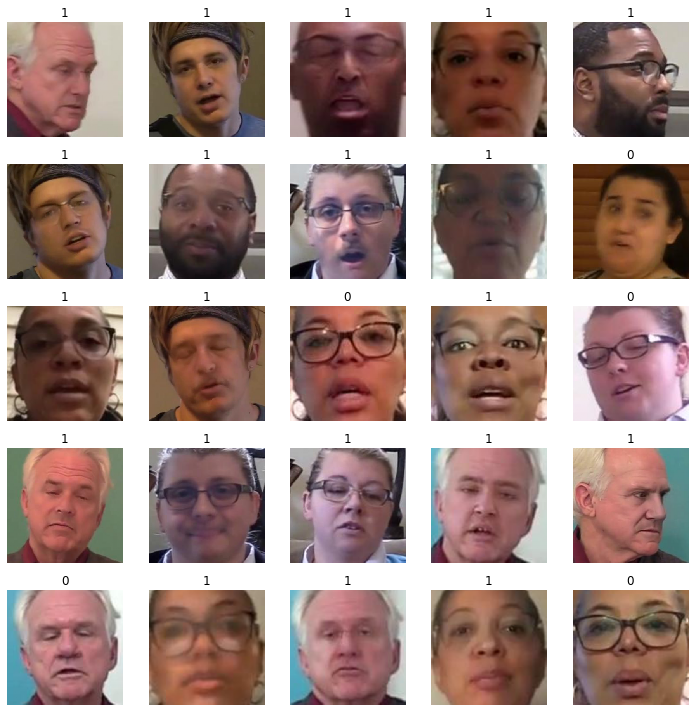

In [35]:
data.show_batch(5, figsize=(10,10))

### transfer learning

In [36]:
import fastai

In [37]:
fastai.__version__

'1.0.60'

In [38]:
split_func = lambda m: (m.block10, m.block12)
learner = Learner(data, model=model, metrics=[accuracy])
learner.split(split_func);

In [39]:
learner.freeze()

In [40]:
# learner.lr_find()
# learner.recorder.plot()

In [41]:
lr=1e-1
learner.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.043270,0.079152,0.968476,06:18


In [42]:
learner.freeze_to(1)

In [43]:
learner.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.036864,0.090100,0.964764,06:37


In [44]:
learner.unfreeze()
learner.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.045183,0.096663,0.962942,08:32


In [45]:
preds = learner.get_preds()

### Show results

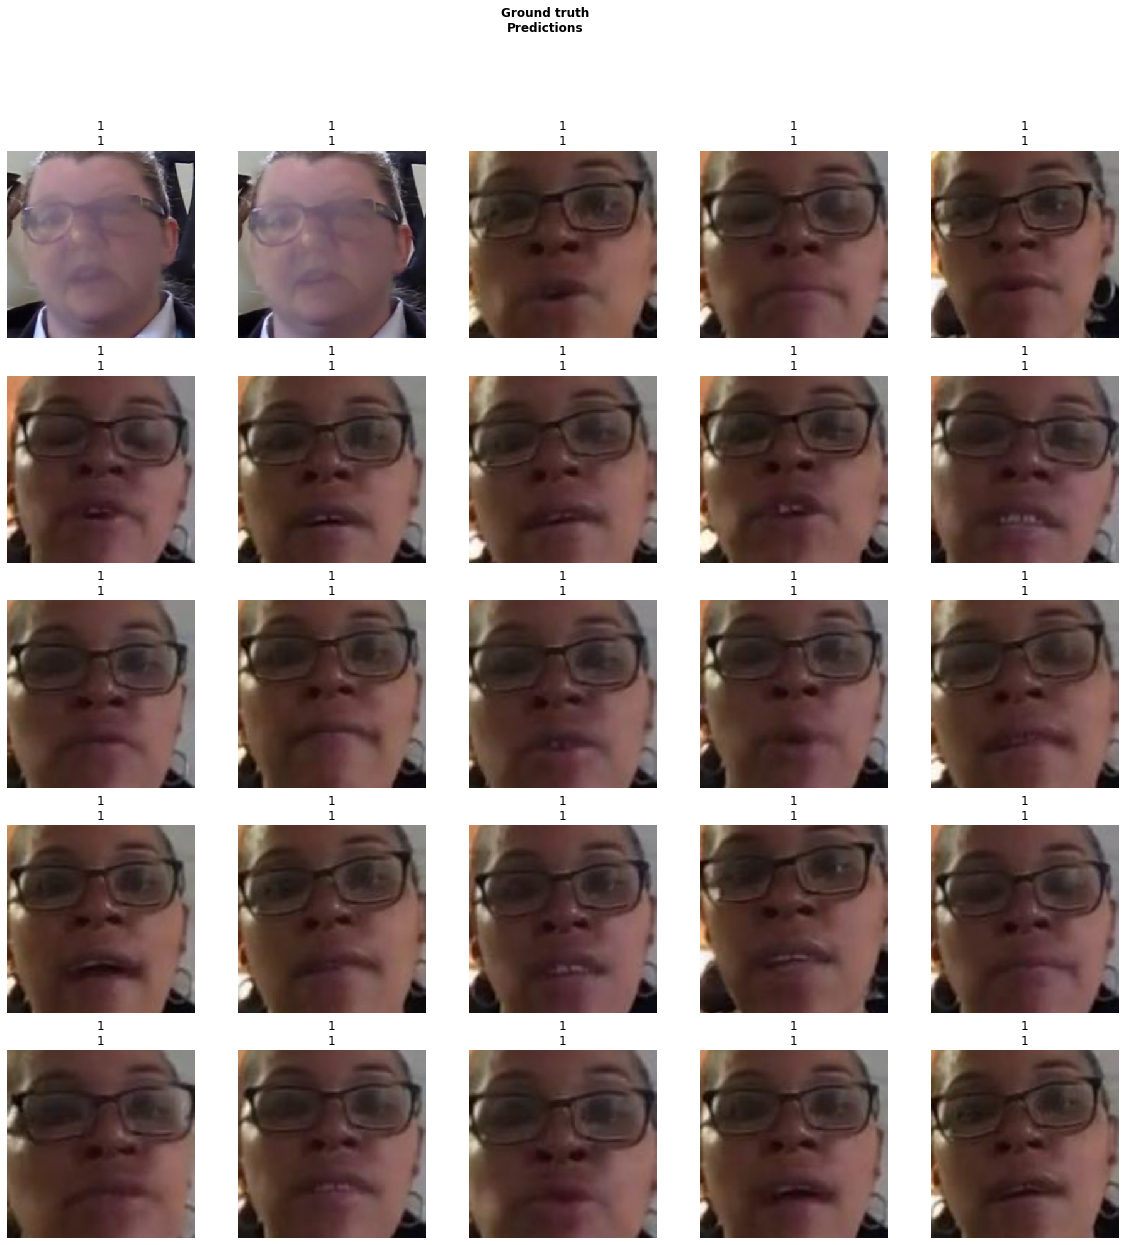

In [46]:
learner.show_results()

In [47]:
learner.path

PosixPath('/home/ubuntu/data/cropped_faces/dfdc_train_part_49')

In [48]:
learner.save("part-49-xception-single-face")

In [49]:
learner.data.valid_ds.get_state()

{'x_cls': fastai.vision.data.ImageList,
 'x_proc': [],
 'y_cls': fastai.data_block.CategoryList,
 'y_proc': [<fastai.data_block.CategoryProcessor at 0x7faa2c1b2250>],
 'tfms': None,
 'tfm_y': False,
 'tfmargs': {'size': 299},
 'tfms_y': None,
 'tfmargs_y': {'size': 299}}